In [1]:
# 기본
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

### 파일패스 설정 ⚠️ 이 부분 꼭 확인해서 설정한 뒤에 실행!!

In [2]:
data_split = ["train","test"]
months = ["07","08","09","10","11","12"]
# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

# local
root_path = '../data/open'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

#### 머신러닝 돌릴 월,카테고리 선택 ⚠️ 이 부분 꼭 확인해서 설정한 뒤에 실행!!

In [3]:
select_month_num = 5
select_category = "승인매출정보"

folder = data_categories[select_category]["folder"]
suffix = data_categories[select_category]["suffix"]

## 간단한 전처리만 한 버전 (1_전치리_단일데이터 에서 전처리한 파일 필요)

### XGBoost 활용해서 모델 학습 및 예측

In [4]:
# 1. 파일 불러오기
#기본 전처리 데이터
file_name=f"{root_path}/{data_split[0]}/{folder}/2018{months[select_month_num]}_processed_{suffix}.parquet"
train_df=pd.read_parquet(file_name)

test_file =f"{root_path}/{data_split[1]}/{folder}/2018{months[select_month_num]}_processed_{suffix}.parquet"
test_df = pd.read_parquet(test_file)


🔷 타겟: Segment_A
✅ 예측 완료 → test_df[f'proba_Segment_A'] 생성됨


<Figure size 1000x600 with 0 Axes>

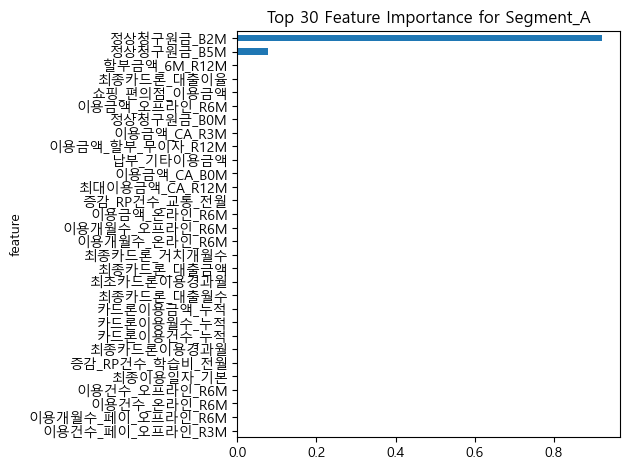


🔷 타겟: Segment_B
✅ 예측 완료 → test_df[f'proba_Segment_B'] 생성됨


<Figure size 1000x600 with 0 Axes>

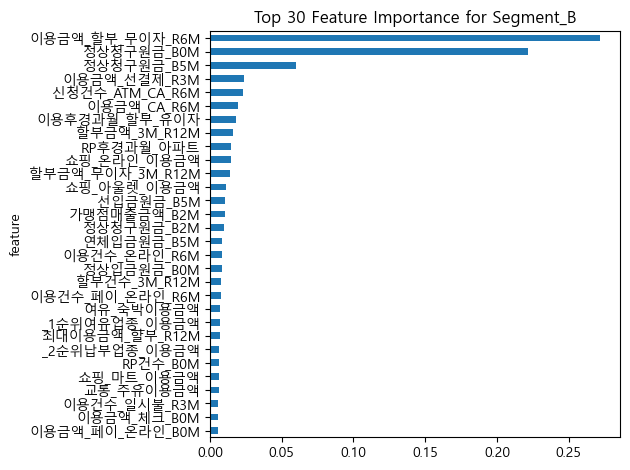


🔷 타겟: Segment_C
✅ 예측 완료 → test_df[f'proba_Segment_C'] 생성됨


<Figure size 1000x600 with 0 Axes>

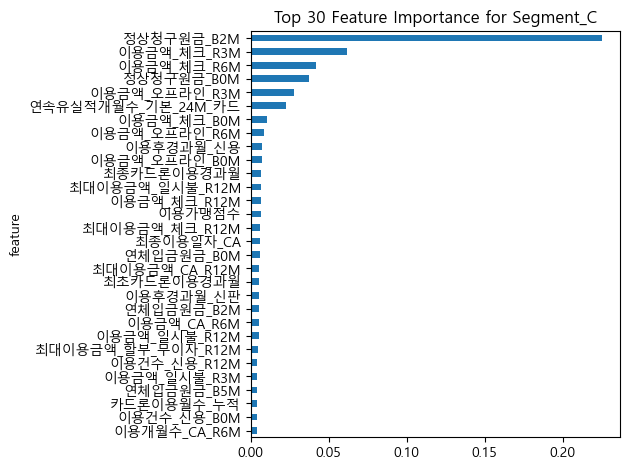


🔷 타겟: Segment_D
✅ 예측 완료 → test_df[f'proba_Segment_D'] 생성됨


<Figure size 1000x600 with 0 Axes>

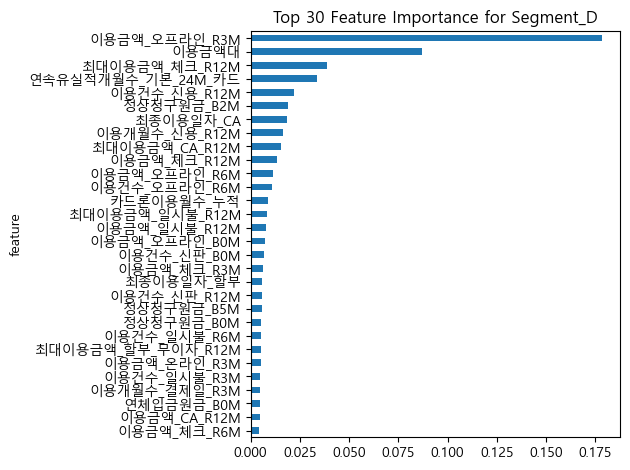


🔷 타겟: Segment_E
✅ 예측 완료 → test_df[f'proba_Segment_E'] 생성됨


<Figure size 1000x600 with 0 Axes>

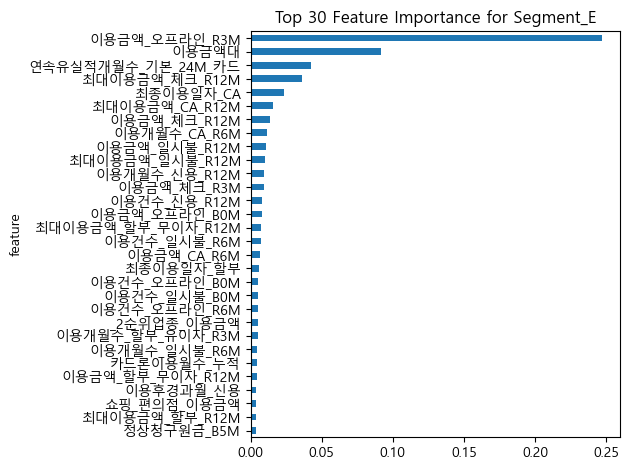

In [5]:
# 2. 공통 피처 추출용 설정
target_cols = ['Segment_A', 'Segment_B', 'Segment_C', 'Segment_D', 'Segment_E']
exclude_cols = ['ID', '기준년월'] + target_cols
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# 3. 결과 저장용
all_results = {}

for target in target_cols:
    print(f"\n🔷 타겟: {target}")
    
    # 학습 데이터
    X_train = train_df[feature_cols]
    y_train = train_df[target]
    
    # 테스트 데이터 (동일한 feature 컬럼만 사용)
    # 그 중 실제 test_df에 존재하는 컬럼만 추출
    valid_feature_cols = [col for col in feature_cols if col in test_df.columns]

    # 적용
    X_test = test_df[valid_feature_cols]
    
    # 1차 모델로 중요도 추출
    model_full = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_full.fit(X_train, y_train)
    
    importance = model_full.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values(by='importance', ascending=False)
    
    # 상위 30개 피처 선택
    top_features = importance_df.head(30)['feature'].tolist()
    
    # 상위 피처만 추려서 다시 학습
    model_top = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_top.fit(X_train[top_features], y_train)

    # 예측 확률 저장 (soft voting)
    y_proba = model_top.predict_proba(X_test[top_features])[:, 1]  # class 1 확률
    test_df[f'proba_{target}'] = y_proba

    print(f"✅ 예측 완료 → test_df[f'proba_{target}'] 생성됨")

    # 시각화
    plt.figure(figsize=(10, 6))
    importance_df.head(30).plot.barh(x='feature', y='importance', legend=False)
    plt.title(f"Top 30 Feature Importance for {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # 결과 저장
    all_results[target] = {
        'top_features': top_features,
        'importance_df': importance_df.head(30)
    }

In [6]:
# 1. 각 타겟별 예측값은 test_df['pred_Segment_X'] 에 저장되어 있다고 가정
segment_labels = ['A', 'B', 'C', 'D', 'E']
proba_cols = [f'proba_Segment_{label}' for label in segment_labels]

# 2. 각 row에서 확률이 가장 높은 컬럼의 label 선택
def get_top_segment(row):
    max_idx = row[proba_cols].values.argmax()
    return segment_labels[max_idx]

# 3. Segment 이름 붙이기
test_df['Segment'] = test_df.apply(get_top_segment, axis=1)

# 4. ID, Segment만 추출
submission = test_df[['ID', 'Segment']]

# 5. 저장
output_file = f"../results/2018{months[select_month_num]}_xgboost_submission_{suffix}.csv"
submission.to_csv(output_file, index=False)

print("✅ 예측 결과가 csv 파일로 저장되었습니다.")

✅ 예측 결과가 csv 파일로 저장되었습니다.
